# ***EXEMPLE DE TRAITEMENTS DES FICHIERS SOURCES***
> exemples pour les FIM, donnees individuelles mixtra, données individuelles viking, ...

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(r'C:\Users\martin.schoreisz\git\otv\otv\Transfert_Donnees')
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import pandas as pd
import geopandas as gp
import numpy as np
import altair as alt
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime
import locale, os

import Donnees_individuelles as di

In [4]:
locale.setlocale(locale.LC_TIME, 'fr_FR')

# 1. Données individuelles mixtra
ces données sont des fichiers excels, sans aucune référence interne au compteur. A chaque véhicule correspond une ligne avec les atributs descroiptifs

In [417]:
mixtra=di.Mixtra(r'Q:\DAIT\TI\CA_Angouleme\2020\C20SA00-09-10-11_Comptage_linearisation_Angouleme\Doc_travail\Donnees_produites\Donnees\Comptages\DonneesBrutes\P11\S1_P11_2.XLS')

Q:\DAIT\TI\CA_Angouleme\2020\C20SA00-09-10-11_Comptage_linearisation_Angouleme\Doc_travail\Donnees_produites\Donnees\Comptages\DonneesBrutes\P11\S1_P11_2.XLS


# 2. Données individuelles viking
ces données sont des fichiers excels, sans aucune référence interne au compteur. A chaque véhicule correspond une ligne avec les atributs descroiptifs

In [146]:
vik=di.Viking(r'Q:\DAIT\TI\CA_Angouleme\2020\C20SA00-09-10-11_Comptage_linearisation_Angouleme\Doc_travail\Donnees_produites\Donnees\Comptages\DonneesBrutes\P9\P9_sens1.VIK')

In [148]:
vik.dfFichier.groupby(['jour']).nbVeh.sum()

jour
1     5908
2     5996
3     5203
4     2827
5     5510
6     5822
7     3398
28    2167
29    5600
30    5491
Name: nbVeh, dtype: int64

# 3. Regroupemnt des deux sens et generalisation a un point de comptage
Anlyser l'extension des fichiers sources et ouvrir avec la classe correspondante.<br> le fonctionnement sse base sur le principe que l'esemble des fichiers d'unpoints de comptage est regroupés dans un dossier

In [2]:
%%time
dossier=r'C:\Users\martin.schoreisz\Documents\AffairesEnCours\projet_plugin_comptage\Re_ donnees_comptage\DonneesBrutes\P9'
cpt=di.ComptageDonneesIndiv(dossier)

Wall time: 23.7 s


In [4]:
cpt.dfHeureTypeSens
cpt.dicoNbJours
cpt.dfMoyenne

In [28]:
#creer le dico qui va contenir tout les résultats et données intermeédiaires 
dicoHoraire,dicoJournalier=di.IndicsGraphs(cpt.dfMoyenne,['vl','pl','2r'],['mja','mjo', 'samedi', 'dimanche'],['sens1','sens2','2sens'])
#récupérer les HPM,HPS,données horaires jour et nuit
hpm,hps,nuit,jour,dfMoyenneHorairesSpeciales=di.IndicsPeriodes(cpt.dfMoyenne)
#recuperer les jours les plus charges
joursCharges=di.JoursCharges(cpt.dfHeureTypeSens)

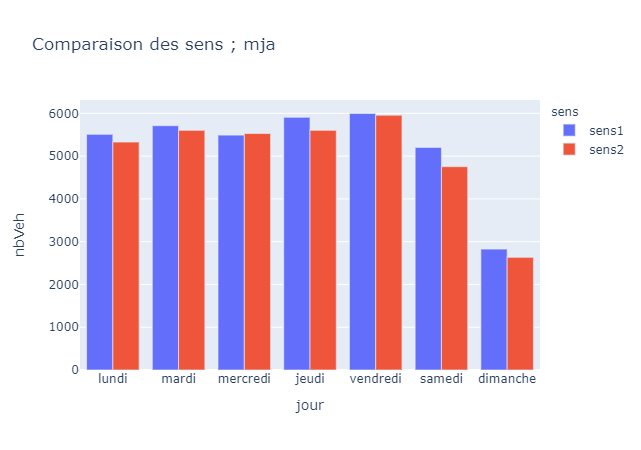

In [16]:
#exemple d'appel de résultats du dico
dicoHoraire['mjo']['nbJour']
dicoHoraire['mja']['nbJour']
dicoHoraire['mjo']['2sens']['graph']
dicoHoraire['samedi']['sens1']['donnees']
dicoJournalier['mja']['sens2']['graph']
dicoJournalier['mjo']['2sens']['graph']
dicoJournalier['mja']['compSens']['graph']

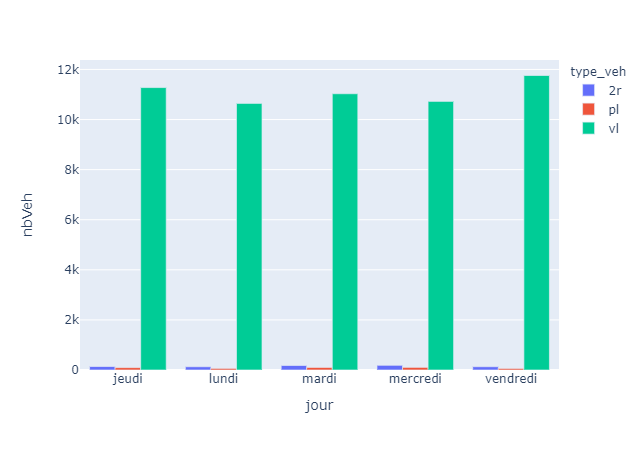

In [32]:
dicoJournalier['mjo']['2sens']['graph']

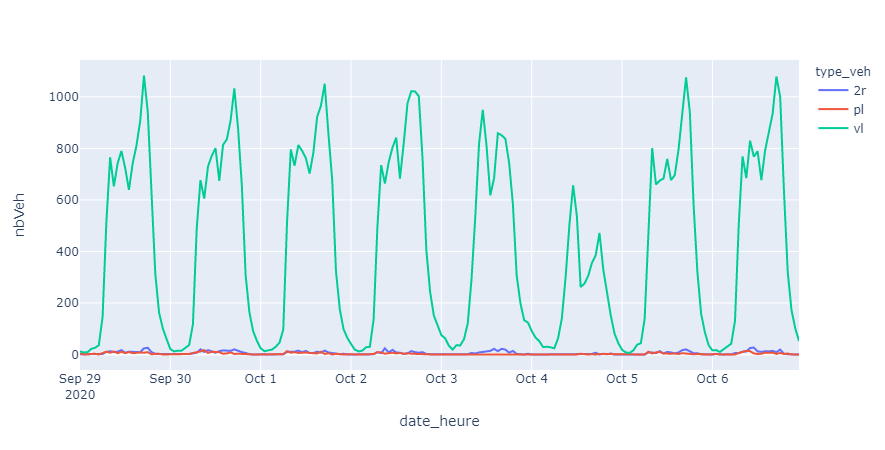

In [36]:
px.line(cpt.dfHeureTypeSens.loc[cpt.dfHeureTypeSens.type_veh.isin(['vl','pl','2r'])].groupby(['date_heure','type_veh']).nbVeh.sum().reset_index(),x='date_heure',y='nbVeh', color='type_veh')

# 4. Traiteement d'1 ensemble de points et export
génarliser le 3 et exporter des données

In [176]:
#dossier source et liste des dossier
dossier_src=r'Q:\DAIT\TI\CA_Angouleme\2020\C20SA00-09-10-11_Comptage_linearisation_Angouleme\Doc_travail\Donnees_produites\Donnees\Comptages\DonneesBrutes'
with os.scandir(dossier_src) as it:
    listPoints=[(os.path.join(dossier_src,f.name),f.name) for f in it if f.is_dir()]

In [177]:
for path in listPoints : 
    print(path)
    if path[1] in('P5','P4','P16','P15') : 
        continue
    cpt2sens=di.ComptageDonneesIndiv(path[0])
    dfHeureTypeSens=di.GroupeCompletude(di.NettoyageTemps(cpt2sens.dfValide))
    dicoHoraire,dicoJournalier=di.IndicsGraphs(dfHeureTypeSens,['vl','pl','2r'],['mja','mjo', 'samedi', 'dimanche'],['sens1','sens2','2sens'])
    hpm,hps,nuit,jour,dfMoyenneHorairesSpeciales=di.IndicsPeriodes(dfHeureTypeSens)
    joursCharges=di.JoursCharges(dfHeureTypeSens)
    #creer le dossier pour les donnees s'il n'existe pas
    chemin=os.path.join(r'Q:\DAIT\TI\CA_Angouleme\2020\C20SA00-09-10-11_Comptage_linearisation_Angouleme\Doc_travail\Donnees_produites\Donnees\Comptages\extractionMartin',path[1])
    if not os.path.exists(chemin) : 
        os.makedirs(chemin)
    dicoHoraire['mja'] ['2sens']['donnees'].sort_values(['sens','type_veh','heure']).to_csv(os.path.join(chemin,'mja_horaire.csv'))
    dicoHoraire['mjo'] ['2sens']['donnees'].sort_values(['sens','type_veh','heure']).to_csv(os.path.join(chemin,'mjo_horaire.csv'))
    joursCharges.to_csv(os.path.join(chemin,'jours_charges.csv'))
    pd.concat([dicoHoraire['samedi']['2sens']['donnees'].assign(jour='samedi'),dicoHoraire['dimanche']['2sens']['donnees'].assign(jour='dimanche')], axis=0
         ).groupby(['jour','heure','type_veh']).nbVeh.sum().reset_index().sort_values(['jour','type_veh', 'heure'], ascending=[False, True,True]).to_csv(
        os.path.join(chemin,'week-end_horaire.csv'))
    dicoJournalier['mja']['2sens']['donnees'].sort_values(['sens','type_veh']).drop('nbOcc', axis=1).to_csv(os.path.join(chemin,'TMJA.csv'))

('Q:\\DAIT\\TI\\CA_Angouleme\\2020\\C20SA00-09-10-11_Comptage_linearisation_Angouleme\\Doc_travail\\Donnees_produites\\Donnees\\Comptages\\DonneesBrutes\\P5', 'P5')
('Q:\\DAIT\\TI\\CA_Angouleme\\2020\\C20SA00-09-10-11_Comptage_linearisation_Angouleme\\Doc_travail\\Donnees_produites\\Donnees\\Comptages\\DonneesBrutes\\P10', 'P10')
('Q:\\DAIT\\TI\\CA_Angouleme\\2020\\C20SA00-09-10-11_Comptage_linearisation_Angouleme\\Doc_travail\\Donnees_produites\\Donnees\\Comptages\\DonneesBrutes\\P16', 'P16')
('Q:\\DAIT\\TI\\CA_Angouleme\\2020\\C20SA00-09-10-11_Comptage_linearisation_Angouleme\\Doc_travail\\Donnees_produites\\Donnees\\Comptages\\DonneesBrutes\\P12', 'P12')
('Q:\\DAIT\\TI\\CA_Angouleme\\2020\\C20SA00-09-10-11_Comptage_linearisation_Angouleme\\Doc_travail\\Donnees_produites\\Donnees\\Comptages\\DonneesBrutes\\P14', 'P14')
('Q:\\DAIT\\TI\\CA_Angouleme\\2020\\C20SA00-09-10-11_Comptage_linearisation_Angouleme\\Doc_travail\\Donnees_produites\\Donnees\\Comptages\\DonneesBrutes\\P2', 'P2')
('